In [1]:
import pandas as pd
import numpy as np

In [2]:
%config Completer.use_jedi = False 

This will be item 2 in what will be a series of posts on mining information from a psql dump of openparliament.ca. This post will be about hypothesis testing, as we can test some of the assumptions that people tend to make about language in politics. 

https://www.lingo-ninja.com/RepsVsDems [#TODO hyperlink that] This article purports to refute the idea that in the US, democrats tend to have a larger vocabulary, with an analysis of words tweeted. In my earlier post, I commented on their methodological choices, and explained how in contrast, for my analysis, I use the pre-trained SpaCy POS tagger to remove named entities, stopwords, punctuation, and then save the lemmas to a Counter object, in order to not overcount different tenses of the same word. 

In [3]:
pol_vocab = pd.read_csv(r"D:\data\openparliament\politician_vocab.csv",index_col='Unnamed: 0')
pol_vocab.head()

,politician_id,riding_id,party_id,end_date,start_date,member_id,vocab_size,token_count,log_words,scaled
0,2693,70159,5,2000-09-11,2000-04-02,2693,3340,161660,11.993251,278.489969
1,2693,70159,4,2001-01-28,2000-09-12,2693,3340,161660,11.993251,278.489969
2,2693,70159,26,2000-04-01,1997-09-22,2693,3340,161660,11.993251,278.489969
3,2693,24016,4,2004-05-23,2001-01-29,2693,3340,161660,11.993251,278.489969
4,4136,59023,4,2005-05-23,2002-01-28,4136,2545,53121,10.880328,233.908398


It wouldn't be fair to compare the vocab sizes without context for how many words they've spoken, so I'm going to count the total tokens spoken per mp.

In [ ]:
df = pd.read_csv(r"D:\data\openparliament\text_en.csv",index_col='Unnamed: 0')

In [ ]:
from ast import literal_eval
df['tokens'] = df.tokens.apply(literal_eval)
df['token_count'] = df.tokens.apply(lambda x: len(x))

In [ ]:
words_spoken = df.pivot_table(index='politician_id', values='token_count', aggfunc=sum)
words_spoken.reset_index(inplace=True)

As you can see here, there are six orders of magnitude between the most and least locquacious members. For this, I'm going to scale the sum of tokens spoken with a natural log.

In [4]:
pol_vocab.scaled.describe()

count    1499.000000
mean      339.769742
std       150.701900
min         0.227560
25%       229.792183
50%       337.468426
75%       441.582375
max       856.785195
Name: scaled, dtype: float64

Note: this bit of consolidation partially happened elsewhere, and I can imagine Quebec people, Green Party,NDP,and various flavours of piqued conservative party* voters protesting in rage that they can't be divided so casually into liberal, conservative, and quebec. Well, this is for the sake of a hypothesis testing demonstration, and there have been many iterations, fractures, and mergers of the Conservative party, but they consist of the same people. Here, for the sake of this analysis, the Conservative Party of Canada, Progressive Conservatives, Canadian Alliance, Reform Party of Canada, and the Canadian Reform Alliance Party (that name didn't last long) shall be treated as just one party. 

In [5]:
party_dict = {1:'con',2:'lib',4:'lib',10: 'con', 3:'quebec', 28:'con', 25:'con', 5:'ind',26:'con', 46:'quebec',9:'lib', 39:'quebec'}

In [6]:
pol_vocab['party'] = pol_vocab.party_id.replace(party_dict)

## The Null Hypothesis

The first thing to do with any hypothesis testing is to decide upon a null hypothesis. That's what you would assume to be true in the simplest version of reality. In this case, I'll assume that since the people who work in the offices of MPs and prepare their speeches are by and large educated in the same places, they more or less write the same. The alternate hypothesis then must be that they're not the same. Remember that with hypothesis testing, the results of your testing will never *prove* your alternate hypothesis. You can only disprove a hypothesis, and the alternate hypothesis then becomes your next best conclusion. 

**H0**: VOCAB^conservatives = VOCAB^liberals

**H1**: Vocab^conservatives != VOCAB^liberals

In [7]:
party_means = pol_vocab.groupby('party').mean()

In [16]:
party_means['vocab_size']

party
con       4544.067290
ind       3900.815789
lib       3661.321965
quebec    3641.533679
Name: vocab_size, dtype: float64

In [21]:
import matplotlib.pyplot as plt

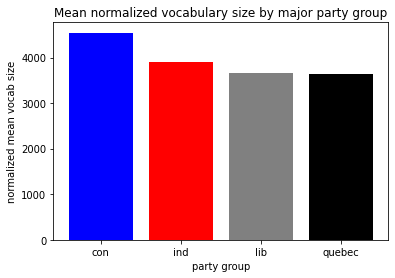

In [27]:
plt.bar(['con', 'ind','lib','quebec'],party_means['vocab_size'],color=['blue','red','gray','black'])
plt.ylabel('normalized mean vocab size')
plt.xlabel('party group')
plt.title('Mean normalized vocabulary size by major party group')
plt.show()

In [9]:
party_stds = pol_vocab.groupby('party').std()

In [10]:
party_stds['vocab_size']

party
con       2085.117271
ind       1901.188787
lib       2136.081279
quebec    1979.218785
Name: vocab_size, dtype: float64

The goal of hypothesis testing is to test whether these two means come from the same distribution. Initially, I planned on going through the calculation by hand - but if you're any kind of programmer, not reinventing the wheel should be your maxim. There are many great libraries for doing all manner of statistical tests, and unless you're using methodology that was just published (and even so!), your first task is to look for a library that will do it for you. 

In [12]:
from scipy.stats import ttest_ind

Since the significance value always has to be decided upon ahead of time, I'm going to choose 0.05 as the P value, as that's the most common value used in experimentation in any field involving biological organisms or psychology.

In [13]:
conservative_vocab = pol_vocab[pol_vocab.party == 'con']['vocab_size']

In [14]:
liberal_vocab = pol_vocab[pol_vocab.party == 'lib']['vocab_size']

In [15]:
stat, p = ttest_ind(conservative_vocab,liberal_vocab)

The ttest_ind function from scipy acts on two array-like structures (arrays or pandas series objects), and gives you the t-score and the p-value. In this case, since we've decided that if p <= 0.05, that is sufficient evidence to reject the null hypothesis, now it's time to see:

In [32]:
p

3.783301607367376e-13

This is in scientific notation, so the p value is ~0.00000000000038, which is a *very* small number. This is sufficient to reject the null hypothesis, that conservatives and liberals have the same vocabulary sizes. Now, I'll admit disappointment at first, there's nothing like running an experiment and missing significance, but this is a reminder to always look at python's scientific notation, even if you're sure you know well. The sadness of missing significance is the sourge of us all.

An alternate hypothesis must be true. While you can't reject the null hypothesis and then claim that whatever alternate hypothesis you have *must* be true, something else must true. Tied to reality as we are, going back to the mean values earlier, the mean adjusted vocabulary size for conservative speeches is 2085, in contrast to 2136 for the liberals. 

The necessary caveat here is that the specific numbers don't mean much here at all - so long as they were arrived at in the same way for all groups. The vocab sizes are adjusted by dividing by the log of total words spoken, and stopwords and proper names were removed from the words in the original vocab size count. 

This is also a reminder to not take this as proof of the blanket statement "conservatives have larger vocabularies than liberals". This is a very specific dataset - speeches on the floor of the house of commons, not the habits, literacy, or skills of people with those political affiliations in general. But, though a hypothesis cannot be proven, exactly, I take this as evidence in support of the somewhat counterintuitive conclusion that conservative MPs use larger vocabularies than liberals. 